# Saving and Loading Models

In this notebook, we'll see how to save and load models with TensorFlow. This is important because you'll often want to load previously trained models to use in making predictions or to continue training on new data.

## Import Resources

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import time
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [2]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [3]:
print('Using:')
print('\t\u2022 TensorFlow version:', tf.__version__)
print('\t\u2022 Running on GPU' if tf.test.is_gpu_available() else '\t\u2022 GPU device not found. Running on CPU')

Using:
	• TensorFlow version: 2.16.1
	• Running on GPU


In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

## Load the Dataset

In [5]:
splits = ['train[:80%]', 'train[80%:]', 'test']

dataset, dataset_info = tfds.load('fashion_mnist', split=splits, as_supervised=True, with_info=True)

training_set, validation_set, test_set = dataset

## Explore the Dataset

In [6]:
print(f'There are {len(training_set):,} images in the training set')
print(f'There are {len(validation_set):,} images in the validation set')
print(f'There are {len(test_set):,} images in the test set')

There are 48,000 images in the training set
There are 12,000 images in the validation set
There are 10,000 images in the test set


In [7]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

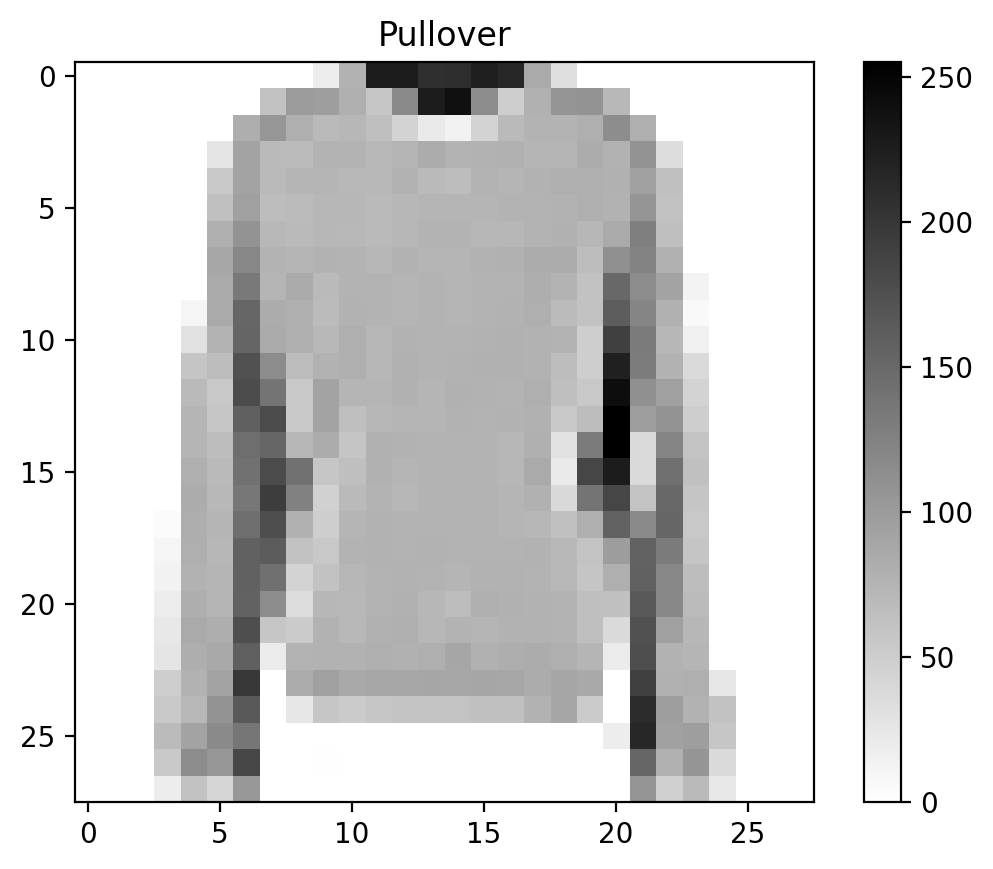

In [8]:
for image, label in training_set.take(1):
    image = image.numpy().squeeze()
    label = label.numpy()

plt.imshow(image, cmap=plt.cm.binary)
plt.title(class_names[label])
plt.colorbar()
plt.show()

## Create Pipeline

In [9]:
def normalize(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255
    return image, label

batch_size = 64
num_training_examples = len(training_set)

training_batches = training_set.cache().shuffle(num_training_examples//4).batch(batch_size).map(normalize).prefetch(1)
validation_batches = validation_set.cache().batch(batch_size).map(normalize).prefetch(1)
testing_batches = test_set.batch(batch_size).map(normalize).prefetch(1)

## Build and Train the Model

Here we'll build and compile our model as usual.

In [10]:
layer_neurons = [512, 256, 128]

dropout_rate = 0.5

model = tf.keras.Sequential()

model.add(tf.keras.layers.Flatten(input_shape=(28,28,1)))

for neurons in layer_neurons:
    model.add(tf.keras.layers.Dense(neurons, activation = 'relu'))
    model.add(tf.keras.layers.Dropout(dropout_rate))

model.add(tf.keras.layers.Dense(10, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0

In [11]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

EPOCHS = 4

history = model.fit(training_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/4


I0000 00:00:1713965474.350547    8711 service.cc:145] XLA service 0x793304a107c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1713965474.350590    8711 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
I0000 00:00:1713965474.350593    8711 service.cc:153]   StreamExecutor device (1): NVIDIA GeForce RTX 2060 SUPER, Compute Capability 7.5
I0000 00:00:1713965474.426987    8711 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


750/750 [==============================] - 15s 4ms/step - loss: 0.8147 - accuracy: 0.7053 - val_loss: 0.4626 - val_accuracy: 0.8255
Epoch 2/4
750/750 [==============================] - 2s 3ms/step - loss: 0.5541 - accuracy: 0.8041 - val_loss: 0.4005 - val_accuracy: 0.8543
Epoch 3/4
750/750 [==============================] - 2s 3ms/step - loss: 0.5069 - accuracy: 0.8212 - val_loss: 0.3907 - val_accuracy: 0.8593
Epoch 4/4
750/750 [==============================] - 2s 3ms/step - loss: 0.4789 - accuracy: 0.8318 - val_loss: 0.3717 - val_accuracy: 0.8633


## Saving and Loading Models

In TensorFlow, we can save our trained models in different formats. Here, we will see how to save our models in the Keras v3 saving format, the Keras HDF5 format, and the TensorFlow SavedModel format.

### Saving and Loading Models in Keras Format

It's advisable to save Keras objects in the Keras v3 format for robust and efficient name-based storage, which is often simpler to debug compared to low-level or legacy formats. You can save a model in Keras v3 format using the `model.save()` method. This will store the model architecture, weights, and training configuration in a zip archive:

```python
my_model.save('test_model.keras')
```

It's important to note that we must provide the `.keras` extension to the `filepath` for `tf.keras` to save our model as a Keras saving format. 

The above command saves our model into a single zip archive that will contain:

* The model's architecture
* The model's weight values (which were learned during training)
* The model's training configuration corresponds to the parameters you passed to the `compile` method.
* The optimizer and its state. This allows you to resume training exactly where you left off.

We'll save our model in the Keras v3 format in the cell below. The name of our model file will correspond to the current time stamp. This is useful if you save many models and want each to have a unique name. By default, the `.save()` method will **silently** overwrite any existing file at the target location with the same name. If we want `tf.keras` to provide us with a manual prompt to overwrite files with the same name, you can set the argument `overwrite=False` in the `.save()` method.

In [12]:
t = time.time()

saved_keras_model_filepath = f'./{int(t)}.keras'

model.save(saved_keras_model_filepath)

The `.keras` file is  a zipped file, so you can simply look inside it.

In [13]:
!unzip -t {saved_keras_model_filepath}

Archive:  ./1713965484.keras
    testing: metadata.json            OK
    testing: config.json              OK
    testing: model.weights.h5         OK
No errors detected in compressed data of ./1713965484.keras.


Here's a breakdown of the files in the Keras v3 file:

1. `metadata.json`: This file stores metadata associated with the model. It might contain information like the Keras version used to save the model, author information, or custom configurations used during training.

2. `config.json`: This file is the core of the model architecture. It describes the complete structure of the model, including the types and configurations of all the layers used (e.g., convolutional layers, dense layers etc.), how they are connected, and any hyperparameters associated with them. Essentially, this file captures the "blueprint" of your model.

3. `model.weights.h5`: This file holds the actual learned weights and biases associated with each layer in the model. During training, the model adjusts these weights to learn patterns from your data. This file is crucial for using the model for predictions, as it contains the knowledge the model has acquired.

Once a model has been saved, we can use `tf.keras.models.load_model(filepath)` to re-load our model. This command will also compile our model automatically using the saved training configuration, unless the model was never compiled in the first place.

In [14]:
reloaded_keras_model = tf.keras.models.load_model(saved_keras_model_filepath)

reloaded_keras_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0

As we can see the re-loaded model has the same architecture as our original model, as it should be. At this point, since we haven't done anything new to the re-loaded model, then both the `reloaded_keras_model` our original `model` should be identical copies. Therefore, they should make the same predictions on the same images. Let's check that this is true:

In [15]:
np.testing.assert_allclose(
    model.predict(testing_batches), reloaded_keras_model.predict(testing_batches)
)

157/157 [==============================] - 0s 1ms/step


### Saving and Loading Models in HDF5 Format

For those intending to utilize models in [TensorFlow.js](https://www.tensorflow.org/js/tutorials/conversion/import_saved_model) for training and execution in web browsers or for conversion to run on mobile devices through [TensorFlow Lite](https://www.tensorflow.org/lite/models/convert/), opting for the legacy [HDF5](https://en.wikipedia.org/wiki/Hierarchical_Data_Format) format is required. To switch to the HDF5 format, you have two options:

- Specify `save_format='h5'` within the `save()` function.
- Utilize a filename with the `.h5` extension.

In [16]:
t = time.time()

saved_h5_model_filepath = f'./{int(t)}.h5'

model.save(saved_h5_model_filepath)

/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


We can be loaded the model, using `tf.keras.models.load_model(filepath)` in the same way as when using the `.keras` format.

In [17]:
reloaded_h5_model = tf.keras.models.load_model(saved_h5_model_filepath)

In [18]:
np.testing.assert_allclose(
    model.predict(testing_batches), reloaded_h5_model.predict(testing_batches)
)

157/157 [==============================] - 0s 1ms/step


### Saving and Loading TensorFlow SavedModels Format

TensorFlow's SavedModel format encapsulates not only the model's weights and architecture but also a serialized representation of the computation graph, making it self-contained and independent of the source code used to create the model. This independence makes SavedModel ideal for deployment across various platforms and environments using frameworks like [TensorFlow Serving](https://www.tensorflow.org/tfx/guide/serving), [TensorFlow Lite](https://www.tensorflow.org/lite/guide), and [TensorFlow.js](https://www.tensorflow.org/js/guide). Furthermore, SavedModel's compatibility with TensorFlow APIs in multiple programming languages such as C, C++, Java, Go, Rust, C#, and others facilitates integration into diverse software systems and workflows, enabling seamless deployment and utilization of TensorFlow models across a wide range of applications.

To export a model to the TensorFlow SavedModel format, use one of the following two methods:

* Pass `save_format='tf'` to `save()`.
* Pass the filename without the extension

In [19]:
t = time.time()

savedModel_directory = f'./{int(t)}'

model.save(savedModel_directory)

A SavedModel is essentially a directory structure containing serialized representations of the model's signatures, along with the necessary state to execute these signatures.

In [20]:
!ls {savedModel_directory}

assets	fingerprint.pb	keras_metadata.pb  saved_model.pb  variables


Here's a breakdown of each component:

1. `saved_model.pb`: This file contains the serialized TensorFlow computational graph, which represents the structure and operations of the model. It also includes a set of named signatures, defining the input and output tensors for different functionalities of the model, such as inference or training.

2. `keras_metadata.pb`: This file stores metadata specific to the Keras model, including information about the Keras version used to save the model, TensorFlow version, model class name, input and output details, and any custom objects used in the model. This metadata provides additional context and details about the saved model.

3. `variables`: This directory contains the standard training [checkpoint](https://www.tensorflow.org/guide/checkpoint), which includes the values of all trainable variables (e.g., weights and biases) of the model. These variables are typically stored in the form of TensorFlow checkpoint files.

4. `assets`: This directory contains any additional files or assets used by the TensorFlow graph during inference or training, such as text files used to initialize vocabulary tables or other supplementary resources. However, it may remain unused in certain cases, depending on the specific requirements of the model.

Once a model has been saved as a SavedModel, we can use `tf.keras.models.load_model(export_dir)` to re-load our model. 

In [21]:
reloaded_SavedModel = tf.keras.models.load_model(savedModel_directory)

In [22]:
np.testing.assert_allclose(
    model.predict(testing_batches), reloaded_keras_model.predict(testing_batches)
)

157/157 [==============================] - 0s 1ms/step


## Saving Models During Training

We have seen that when we train a model with a validation set, the value of the validation loss changes throughout the training process. Since the value of the validation loss is an indicator of how well our model will generalize to new data, it would be great if we could save our model at each step of the training process and then only keep the version with the lowest validation loss. 

We can do this in `tf.keras` by using the following callback:

```python
tf.keras.callbacks.ModelCheckpoint('./best_model.keras', monitor='val_loss', save_best_only=True)
```
This callback will save the model in Keras format after every epoch. With the `save_best_only=True` argument, it will first check the validation loss of the latest model against the one previously saved. The callback will only save the newest model and overwrite the old one if it has a lower validation loss than the one previously saved. This will guarantee that we will end up with the version of the model that achieved the lowest validation loss during training.

In [23]:
model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28,28,1)),
        tf.keras.layers.Dense(256, activation = 'relu'),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dense(10, activation = 'softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Stop training when there is no improvement in the validation loss for 10 consecutive epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Save the Model with the lowest validation loss
save_best = tf.keras.callbacks.ModelCheckpoint('./best_model.keras',
                                               monitor='val_loss',
                                               save_best_only=True)

history = model.fit(training_batches,
                    epochs = 100,
                    validation_data=validation_batches,
                    callbacks=[early_stopping, save_best])

Epoch 1/100
750/750 [==============================] - 4s 3ms/step - loss: 0.5224 - accuracy: 0.8177 - val_loss: 0.4028 - val_accuracy: 0.8516
Epoch 2/100
750/750 [==============================] - 2s 3ms/step - loss: 0.3781 - accuracy: 0.8610 - val_loss: 0.3496 - val_accuracy: 0.8687
Epoch 3/100
750/750 [==============================] - 2s 3ms/step - loss: 0.3394 - accuracy: 0.8741 - val_loss: 0.3199 - val_accuracy: 0.8806
Epoch 4/100
750/750 [==============================] - 2s 3ms/step - loss: 0.3174 - accuracy: 0.8827 - val_loss: 0.3147 - val_accuracy: 0.8839
Epoch 5/100
750/750 [==============================] - 2s 3ms/step - loss: 0.2967 - accuracy: 0.8910 - val_loss: 0.3166 - val_accuracy: 0.8843
Epoch 6/100
750/750 [==============================] - 2s 3ms/step - loss: 0.2812 - accuracy: 0.8942 - val_loss: 0.3392 - val_accuracy: 0.8785
Epoch 7/100
750/750 [==============================] - 2s 3ms/step - loss: 0.2677 - accuracy: 0.8993 - val_loss: 0.2912 - val_accuracy: 0.8938